#Paquetes necesarios

In [1]:
import cv2  
import math 
import matplotlib.pyplot as plt
import pytesseract
from ultralytics import YOLO

Desde cámara, detección con yolov8 y modelo nano. Visualización propia


0: 512x640 1 person, 2 cars, 1 truck, 96.9ms
Speed: 4.6ms preprocess, 96.9ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 640)
Confidence ---> 0.47
Confidence ---> 0.42
A3714LVWE



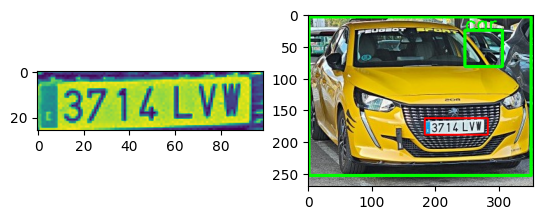

In [1]:
#declaramos pytesseract para luego utilizarlo al detectar la matrícula
pytesseract.pytesseract.tesseract_cmd = r'C:/Program Files/Tesseract-OCR/tesseract'

# img = cv2.imread('bmw.jpg')
img = cv2.imread('images/Spain License Plate (49)..jpg')

model = YOLO('yolov8n.pt') #Contenedores

# Nombre de las distintas clases
classNames = ["person", "bicycle", "car", "motorbike", "aeroplane", "bus", "train", "truck", "boat",
              "traffic light", "fire hydrant", "stop sign", "parking meter", "bench", "bird", "cat",
              "dog", "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe", "backpack", "umbrella",
              "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard", "sports ball", "kite", "baseball bat",
              "baseball glove", "skateboard", "surfboard", "tennis racket", "bottle", "wine glass", "cup",
              "fork", "knife", "spoon", "bowl", "banana", "apple", "sandwich", "orange", "broccoli",
              "carrot", "hot dog", "pizza", "donut", "cake", "chair", "sofa", "pottedplant", "bed",
              "diningtable", "toilet", "tvmonitor", "laptop", "mouse", "remote", "keyboard", "cell phone",
              "microwave", "oven", "toaster", "sink", "refrigerator", "book", "clock", "vase", "scissors",
              "teddy bear", "hair drier", "toothbrush"
              ]


results = model(img, stream=True)
car_detections = [box for r in results for box in r.boxes if classNames[int(box.cls[0])] == "car"]
plt.figure()
# Dibujar las detecciones de la clase "car"
for box in car_detections:
    
    confidence = math.ceil((box.conf[0] * 100)) / 100
    if (confidence > 0):
        x1, y1, x2, y2 = map(int, box.xyxy[0])
        
        print("Confidence --->", confidence)

        cls = int(box.cls[0])

        # --Deteccion de matricula
        # Conseguir rectángulo mínimo que contiene al coche
        roi = img[y1:y2, x1:x2]

        # Convertir la ROI a escala de grises
        gray_roi = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)

        # Aplicar umbralización
        _, threshold = cv2.threshold(gray_roi, 127, 255, cv2.THRESH_BINARY)

        # Encontrar contornos en la imagen umbralizada
        contours, _ = cv2.findContours(threshold, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Iterar sobre los contornos para encontrar un rectángulo que parezca una matrícula
        for contour in contours:
            # Ajustar un rectángulo al contorno
            x, y, w, h = cv2.boundingRect(contour)
            area = cv2.contourArea(contour)
            perimeter = 0.05*cv2.arcLength(contour, True) #Perímetro del contorno con una corrección para aplicar la aproximación de los lados a posteriori
            approx = cv2.approxPolyDP(contour, perimeter, True) #Aproximación de los lados

            if len(approx) == 4 and w/h > 3 and area > 1000: 
                # Dibujar el rectángulo en la imagen original
                cv2.rectangle(img, (x1 + x, y1 + y), (x1 + x + w, y1 + y + h), (0, 0, 255), 2)
                plate = gray_roi[y:y+h, x:x+w]
                plt.subplot(1, 2, 1)
                plt.imshow(plate)
                text = pytesseract.image_to_string(plate)
                print(text)

        cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 3)
        cv2.putText(img, classNames[cls], [x1, y1], cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2) 
        #Se pasa a la función auxiliar el texto detectado por la función del wrap pytesseract
        

# Mostrar la imagen con las detecciones de la clase "car"
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.subplot(1, 2, 2)
plt.imshow(img_rgb)
plt.show()

Uso de YOLOV8 entrenado para detectar matrículas


0: 128x192 (no detections), 23.7ms
Speed: 1.0ms preprocess, 23.7ms inference, 1.0ms postprocess per image at shape (1, 3, 128, 192)


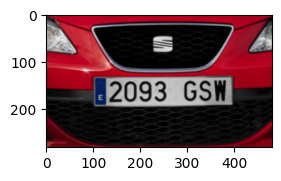

In [1]:
import cv2  
import math 
import matplotlib.pyplot as plt
import pytesseract
from ultralytics import YOLO

pytesseract.pytesseract.tesseract_cmd = r'C:/Program Files/Tesseract-OCR/tesseract'

plt.figure()

def text_processing(text):
    result = ""
    for i in text:
        if i.isalnum(): #Si es letra o número devuelve true
            result += i
    return result

#56, 49, mt 1, mt 2, 
img = cv2.imread('images/matricula foto 3.png')

#se carga el modelo pre-entrenado
model = YOLO(f'../runs/detect/train5/weights/best.pt') 

results = model(img, stream=True)
plate_detections = [box for r in results for box in r.boxes]

# Dibujar las detecciones de la clase "car"
for box in plate_detections:
   
        x1, y1, x2, y2 = map(int, box.xyxy[0])
        x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
       
        #Se pasa a la función auxiliar el texto detectado por la función del wrap pytesseract
        #gray_roi = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
        plate = img[y1:y2, x1:x2]
        plt.subplot(1, 2, 1)
        plt.imshow(plate)
        cv2.imwrite('plate1'+'.png', plate)
        text = pytesseract.image_to_string(plate)
        print(text)   

        cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 3)
        cv2.putText(img, "plate", [x1, y1], cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2) 
         
        

# Mostrar la imagen con las detecciones de la clase "car"
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.subplot(1, 2, 2)
plt.imshow(img_rgb)
plt.show()